In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
import matplotlib.animation as animation
import matplotlib
from IPython.display import HTML

## How to simulate n-pendulums

Article: https://arxiv.org/pdf/1910.12610

The Lagrangian equation:

$$
\begin{align}
&\sum_{k=1}^{n}\left[gl_{j}\sin(\theta_{j})m_{k}\sigma_{jk}+m_{k}l_{j}^2\ddot{\theta}_{j}\sigma_{jk}\right.+ \\
&(\sum_{q\ge k}^{n}m_{q}\sigma_{jq})l_{j}l_{k}\left(\sin\left(\theta_{j}-\theta_{k}\right)\dot{\theta}_{k}^2+\phi_{jk}\cos\left(\theta_{j}-\theta_{k}\right)\ddot{\theta_k}\right)\Big]=0
\end{align}
$$

Vectorize it:

$$
\begin{align} & b=-\sum_{k=1}^{n}\left(gl_{j}\sin(\theta_{j})m_{k}\sigma_{jk}+(\sum_{q\ge k}^{n}m_{q}\sigma_{jq})l_{j}l_{k}\sin\left(\theta_{j}-\theta_{k}\right)\dot{\theta}_{k}^2\right)\\  & M=(\sum_{k=1}^{n}m_{k}l_{j}^2\sigma_{jk})\delta_{jk}+(\sum_{q\ge k}^{n}m_{q}\sigma_{jq})l_{j}l_{k}\phi_{jk}\cos\left(\theta_{j}-\theta_{k}\right)\end{align}
$$

where $M\ddot{\theta}=b$. Solving this equation, we can obtain the acceleration.

In [31]:
class Pendulums:
    def __init__(self, L, m, theta, dtheta, n, g, iter, t):
        self.L = L
        self.m = m
        self.theta = theta
        self.dtheta = dtheta
        self.n = n
        self.g = g
        self.iter = iter
        self.t = t
        self.ts = np.linspace(0, t, iter)
        self.dt = self.ts[1] - self.ts[0]
        self.gen_sigma()
        self.gen_phi()
        self.gen_mass_term()
        
        self.thetas = np.zeros((self.n, self.iter))
        self.dthetas = np.zeros((self.n, self.iter))

    # 0 if j > k
    # 1 if j <= k
    def gen_sigma(self):
        self.sigma = np.triu(np.ones(self.n))

    # 0 if j == k
    # 1 if j != k
    def gen_phi(self):
        phi = np.ones((self.n, self.n))
        for (i,j), _ in np.ndenumerate(phi):
            if i == j:
                phi[i, j] = 0
        self.phi = phi

    # (sum_q m_q sigma_jq) l_j l_k
    def gen_mass_term(self):
        mass_term = np.zeros((self.n, self.n))
        for j in np.arange(self.n):
            for k in np.arange(self.n):
                mass = 0
                for q in np.arange(k, self.n):
                    mass += self.m[q] * self.sigma[j, q]
                mass_term[j, k] = mass
        self.mass_term = mass_term * np.outer(self.L, self.L)

    def A(self, theta):
        # (sum_k m_k l_j^2 sigma_jk) delta_jk
        A1 = np.diag(np.sum(np.multiply.outer(self.L**2, self.m) * self.sigma, axis=1))
        # (sum_q m_q sigma_jq) l_j l_k phi_jk cos(theta_j - theta_k)
        A2 = np.cos(np.subtract.outer(theta, theta)) * self.phi * self.mass_term
        return A1 + A2

    def b(self, theta, dtheta):
        # g l_j sin(theta_j) m_k sigma_jk
        b1 = self.g * np.outer(self.L * np.sin(self.theta), self.m) * self.sigma
        # (sum_q m_q sigma_jq) l_j l_k sin(theta_j - theta_k) dtheta_k^2
        b2 = self.mass_term * np.sin(np.subtract.outer(theta, theta)) * dtheta ** 2

        return np.sum(-b1 - b2, axis=1)

    def f(self, theta, dtheta):
        return dtheta, np.linalg.solve(self.A(theta), self.b(theta, dtheta))
    
    def ft(self, t, stacked):
        theta = stacked[:self.n]
        dtheta = stacked[self.n:]
        return np.hstack([dtheta, np.linalg.solve(self.A(theta), self.b(theta, dtheta))])
    
    def RK4(self, dt, theta, dtheta):
        k1 = self.f(theta, dtheta)
        k2 = self.f(theta + k1[0] * dt / 2, dtheta + k1[1] * dt / 2)
        k3 = self.f(theta + k2[0] * dt / 2, dtheta + k2[1] * dt / 2)
        k4 = self.f(theta + k3[0] * dt, dtheta + k3[1] * dt)
        theta_delta = theta + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
        dtheta_delta = dtheta + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])

        return theta_delta, dtheta_delta

    def RK45_scipy(self, dt, theta, dtheta):
        stacked = np.hstack([theta, dtheta])
        return RK45(self.ft, 0, stacked, t_bound=dt)
    
    def Euler(self, dt, theta, dtheta):
        dtheta_t, ddtheta_t = self.f(theta, dtheta)
        return theta + dtheta_t * dt, dtheta + ddtheta_t * dt

    def update(self, mode):
        if mode == 'RK4':
            self.theta, self.dtheta = self.RK4(self.dt, self.theta, self.dtheta)
        elif mode == 'RK45':
            # res = self.RK45_scipy(self.dt, self.theta, self.dtheta)
            # self.theta = 
            raise ValueError('RK45 is not ready yet')
        elif mode == 'Euler':
            self.theta, self.dtheta = self.Euler(self.dt, self.theta, self.dtheta)

    def store(self, i):
        self.thetas[:, i] = self.theta
        self.dthetas[:, i] = self.dtheta

    def experiment(self, mode):
        self.store(0)
        for i, t in enumerate(self.ts):
            self.update(mode)
            if i != 0:
                self.store(i)

    def convert_xy(self):
        x = np.zeros((self.n, self.iter))
        y = np.zeros((self.n, self.iter))
        for j in np.arange(self.n):
            if j == 0:
                x[j, :] = self.L[j] * np.sin(self.thetas[j, :])
                y[j, :] = -self.L[j] * np.cos(self.thetas[j, :])
            else:
                x[j, :] = x[j - 1, :] + self.L[j] * np.sin(self.thetas[j, :])
                y[j, :] = y[j - 1, :] - self.L[j] * np.cos(self.thetas[j, :])
        return x, y

In [43]:
# double pendulum
L = np.array([2, 3])
m = np.array([1, 2])
theta = np.array([1.4, -1.3])
dtheta = np.array([-2, -4])
n = len(L)
d = Pendulums(L, m, theta, dtheta, n, 9.8, 1000, 10)

In [44]:
d.experiment('RK4')

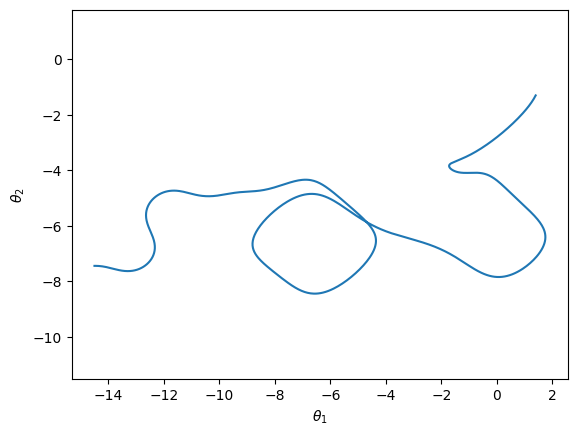

In [45]:
plt.plot(d.thetas[0], d.thetas[1])
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.axis('equal')
plt.show()

In [47]:
# quaduple pendulum
L = np.array([2, 3, 2, 1])
m = np.array([1, 2, 1, 2])
theta = np.array([1.4, -1.3, 1, 2])
dtheta = np.array([-2, -4, 1, -0.5])
n = len(L)
d = Pendulums(L, m, theta, dtheta, n, 9.8, 1000, 10)

In [48]:
d.experiment('RK4')

In [49]:
xs, ys = d.convert_xy()

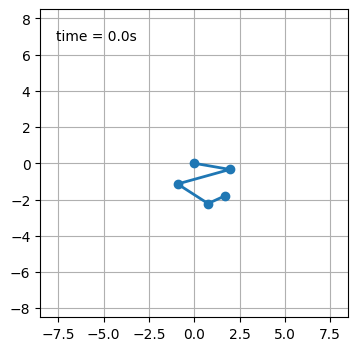

In [50]:
matplotlib.rcParams['animation.embed_limit'] = 1024*1024*100
plt.rcParams["animation.html"] = "jshtml"
fig = plt.figure(figsize=(5, 4))
L = np.sum(d.L)
ax = fig.add_subplot(autoscale_on=False, xlim=(-L - 0.5, L + 0.5), ylim=(-L - 0.5, L + 0.5))
ax.set_aspect('equal')
ax.grid()
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], '.-', lw=1, ms=2)
trace2, = ax.plot([], [], '.-', lw=1, ms=2)

def animate(i):
    thisx = [0]
    thisy = [0]
    for j in range(d.n):
        thisx.append(xs[j, i])
        thisy.append(ys[j, i])

    history_x = xs[-1, :i]
    history_y = ys[-1, :i]

    history_x2 = xs[-2, :i]
    history_y2 = ys[-2, :i]

    line.set_data(thisx, thisy)
    trace.set_data(history_x, history_y)
    trace2.set_data(history_x2, history_y2)
    time_text.set_text(time_template % (i*d.dt))
    return line, trace, time_text


ani = animation.FuncAnimation(
    fig, animate, d.iter, interval=d.dt*d.iter, blit=True)
plt.show()

In [51]:
HTML(ani.to_html5_video())